## SVM-SMO

SVM-SMO 实现。

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
def loadData(file, names):
    return pd.read_csv(file, delimiter='\t', names = names)
    

In [307]:
def linearKernel(X, x, kernelParams=None):
    '''
        线性核
    '''
    return X * x.T

In [386]:
class SVM(object):
    '''
        Using SMO to implement SVM.
    '''
    def __init__(self, data, labels, C = 10, toler = 0.001, kernel = linearKernel, kernelParams=None):
        self.X, self.y = np.mat(data), np.mat(labels)
        self.C, self.toler = C, toler
        self.m, self.n = data.shape
        self.alphas = np.mat(np.zeros((self.m, 1)))
        self.b = 0
        self.eCache = np.mat(np.zeros((self.m, 2)))
        self.kernel, self.kernelParams = kernel, kernelParams
        self.K = np.mat(np.zeros((self.m, self.m)))
        for i in range(self.m):
            self.K[:, i] = kernel(self.X, self.X[i], kernelParams)
        return
    
    def calcEk(self, k):
        '''
            计算误差；将只有一个元素的矩阵转换成 scalar 可以用:
            1. np.squeeze(np.asarray(y[0]))[0]
            2. y[0].A[0][0]
            3. 最简单的方法直接用 float, int 转换函数就可以了。
        '''
        # fk = float(np.multiply(self.alphas, self.y).T * self.X * self.X[k].T + self.b)
        # use kernel
        fk = float(np.multiply(self.alphas, self.y).T * self.K[:, k] + self.b)
        Ek = fk - float(self.y[k])
        return Ek
    
    def selectJrand(self, i):
        '''
            从样本中随机选择一个不等于 i 的样本。
        '''
        j = i
        while (j == i):
            j = int(np.random.uniform(0, self.m))
        return j
    
    def selectJ(self, i, Ei):
        '''
            根据样本 i 使用启发式搜索第二个样本 j。第二个样本确保有最大更新步长。
            我是从缓存的误差来选择具有最大更新步长的 j。如果没有满足的缓存的误差则直接随机选择一个。
        '''
        j = -1; maxDeltaE = 0; Ej = 0
        self.eCache[i] = [1, Ei]
        
        cachedList = np.nonzero(self.eCache[:, 0].A)[0]
        if len(cachedList) > 1:
            for k in cachedList:
                if k == i: continue
                Ek = self.calcEk(k)
                deltaE = abs(Ei - Ek)
                if (deltaE > maxDeltaE):
                    j, Ej, maxDeltaE = k, Ek, deltaE
        else:
            j = self.selectJrand(i)
            Ej = self.calcEk(j)
        return j, Ej  
    
    def clipAlpha(self, aj, H, L):
        if aj > H:
            return H
        elif aj < L:
            return L
        return aj
    
    def updateEk(self, j):
        Ej = self.calcEk(j)
        self.eCache[j] = [1, Ej]
        return

    def examineExample(self, i, printLog):
        '''
            根据样本 i 来搜索样本 j。然后优化 alpha_i 和  alpha_j。
            如果能够进行更新则返回 1；否则返回 0；
            j 是 alpha_2
            i 是 alpha_1
        '''
        Ei = self.calcEk(i)
        si = Ei * self.y[i] 
        
        # 选择非边界上的样本。
        if ((si < -self.toler and self.alphas[i] < self.C) or (si > self.toler and self.alphas[i] >0)):
            j, Ej = self.selectJ(i, Ei)
            ai_old, aj_old = self.alphas[i].copy(), self.alphas[j].copy()
            yi, yj = self.y[i], self.y[j]
            if (yi != yj):
                L = max(0, self.alphas[j] - self.alphas[i])
                H = min(self.C, self.C + self.alphas[j] - self.alphas[i])
            else:
                L = max(0, self.alphas[j] + self.alphas[i] - self.C)
                H = min(self.C, self.alphas[j] + self.alphas[i])
            if L == H: 
                if printLog : print('L == H')
                return 0
            
            # eta = 2.0 * self.X[i] * self.X[j].T - self.X[i] * self.X[i].T - self.X[j] * self.X[j].T
            # use kernel
            eta = 2.0 * self.K[i, j] - self.K[i, i] - self.K[j, j]
            if (eta >= 0):
                if printLog : print('Eta >= 0')
                return 0
            
            self.alphas[j] -= self.y[j] * (Ei - Ej) / eta
            self.alphas[j] = self.clipAlpha(self.alphas[j], H, L)
            self.updateEk(j)
            
            if (abs(self.alphas[j] - aj_old) < 0.00001):
                if printLog : print('j not moving enough')
                return 0
            
            self.alphas[i] += self.y[j] * self.y[i] * (aj_old - self.alphas[j])
            self.updateEk(i)
            
            b1 = self.b - Ei \
                - self.y[i] * (self.alphas[i] - ai_old) * self.K[i, i]  \
                - self.y[j] * (self.alphas[j] - aj_old) * self.K[i, j] 
            
            b2 = self.b - Ej \
                - self.y[i] * (self.alphas[i] - ai_old) * self.K[i, j]  \
                - self.y[j] * (self.alphas[j] - aj_old) * self.K[j, j] 
            if (self.alphas[i] > 0) and (self.alphas[i] < self.C): self.b = b1
            elif (self.alphas[j] > 0) and (self.alphas[j] < self.C): self.b = b2
            else: self.b = (b1 + b2) / 2.0
            return 1
        else:
            return 0
        
        pass
        return 1
     
    def smo(self, maxIters = 30, printLog = False):
        '''
            SMO 外循环
        '''
        iters = 0
        examineAll = True
        numChanged = 0
        while ((numChanged > 0 or examineAll) and iters < maxIters):
            numChanged = 0
            iters += 1
            if (examineAll): # 遍历所有样本
                for i in range(self.m):
                    numChanged += self.examineExample(i, printLog)
                    if printLog : 
                        print('Examine All, iter: {0}, i: {1}, pairs changed {2}'.format(iters, i, numChanged))
            else: # 遍历所有非边界上的值，即 0 < alpha < c
                nonBoundIds = np.nonzero((self.alphas.A != 0) * (self.alphas.A != self.C))[0]
                for i in nonBoundIds:
                    numChanged += self.examineExample(i, printLog)
                    if printLog :
                        print('Non bound, iter: {0}, i: {1}, pairs changed {2}'.format(iters, i, numChanged))
            if examineAll: 
                examineAll = False
            elif numChanged == 0: # 如非边界值对应的样本都遍历过了，还是没有更新那么就遍历所有的样本来搜索。
                examineAll = True
                
        return self.b, self.alphas
    
    def calcWs(self):
        return self.X.T * np.multiply(self.alphas, self.y)
    
    def predict(self, x):
        '''
            预测样本，仅需要使用非 0 alphas 就可以了。
        '''
        svs = np.nonzero(self.alphas.A > 0)[0]
        return  self.kernel(self.X[svs], x, self.kernelParams).T * np.multiply(self.alphas[svs], self.y[svs]) + b
    

In [289]:
def plotSVM(X, y, results):
    m = len(results)
    cols = 3
    rows = int(m/3)
    fig, axes = plt.subplots(nrows=rows, ncols=cols, sharex=True, sharey=False, figsize=(10 * rows, 5 * cols))
    
    for i in range(rows):
        for j in range(cols):
            ax = axes[i, j]
            # 画出正负样本，和支持向量
            alphas, ws, b = results[i * cols + j]
            positives = X[np.nonzero(y == 1)[0], :]
            negatives = X[np.nonzero(y != 1)[0], :]
            supportVectors = X[np.nonzero(alphas > 0)[0], :]
            
            ax.scatter(positives[:, 0], positives[:, 1], marker='+')
            ax.scatter(negatives[:, 0], negatives[:, 1], c='g')
            ax.scatter(supportVectors[:, 0], supportVectors[:, 1], s=100, facecolors='none', edgecolors='r')
            
            # 画出超平面
            x0 = np.arange(0, 8, 0.1)
            x1 = -(float(ws[0]) * x0 + float(b)) / float(ws[1])
            ax.plot(x0, x1)

[[ 0.65307162 -0.17196128]] [[-2.89901748]]
[[ 0.65307162 -0.17196128]] [[-2.89901748]]
[[ 0.75824561 -0.1716433 ]] [[-3.5386688]]
[[ 0.58345952 -0.33309233]] [[-2.40824051]]
[[ 0.65307162 -0.17196128]] [[-2.89901748]]
[[ 0.6403022  -0.24677221]] [[-2.96714884]]
[[ 0.65307162 -0.17196128]] [[-2.89901748]]
[[ 0.71469266 -0.36249171]] [[-3.19389817]]
[[ 0.544686   -0.39671182]] [[-2.14582596]]


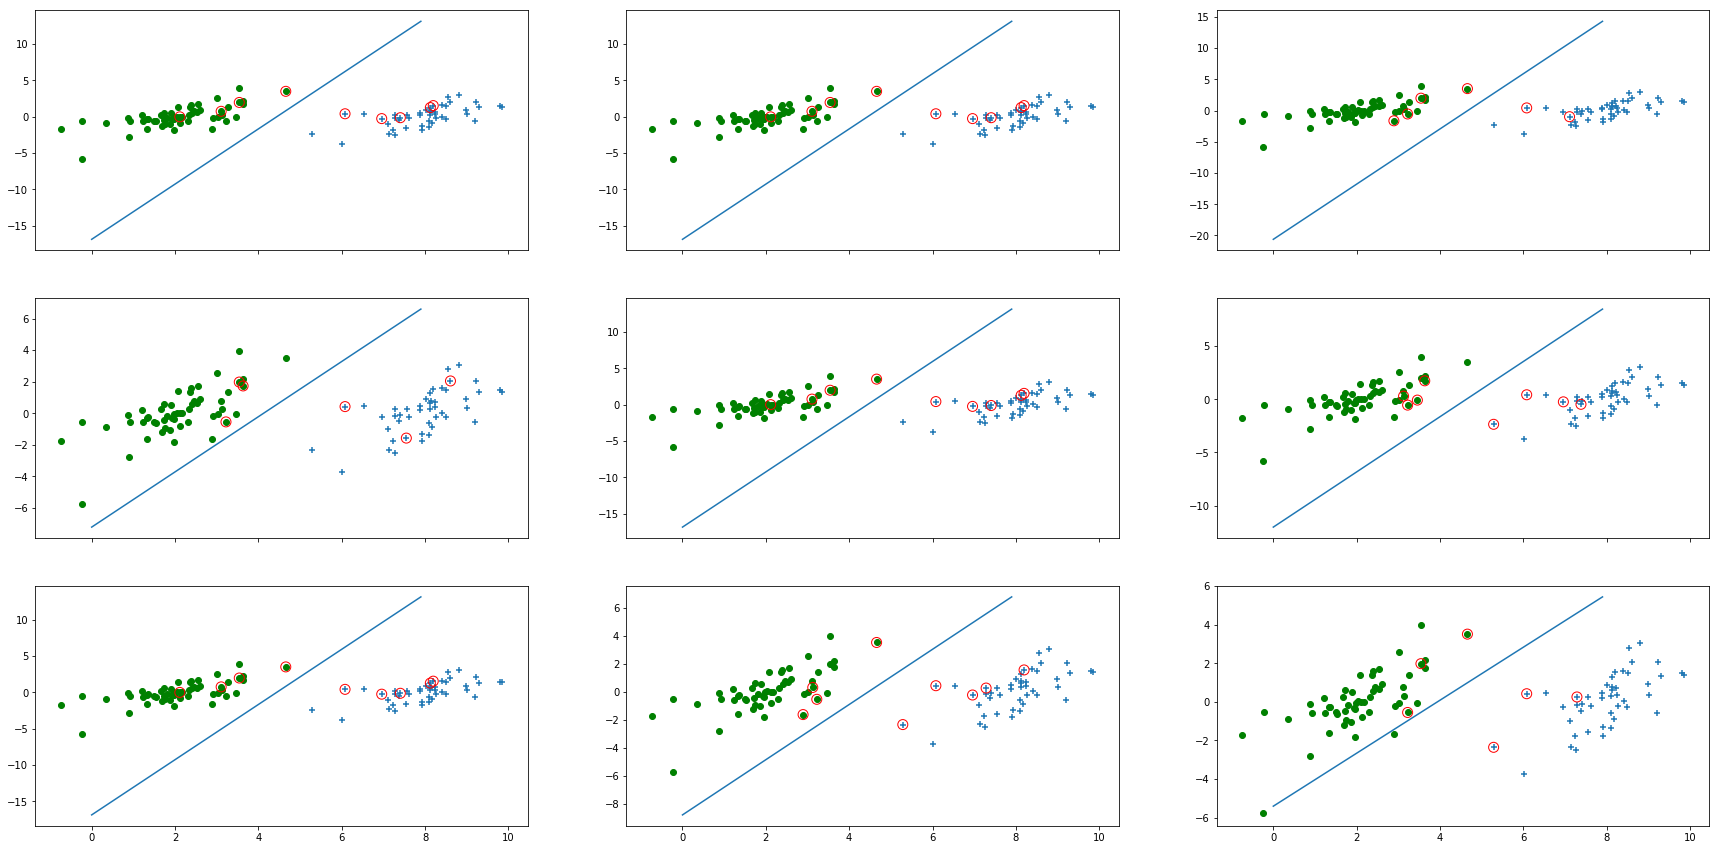

In [387]:
df = loadData('testSet.txt', names=['x1', 'x2', 'label'])
m, n = df.values.shape
X, y = df.values[:, 0:-1], df.values[:, -1:m]

hyperParameters = [
    (0.2, 0.0001, 40),
    (0.4, 0.0001, 40),
    (0.6, 0.0001, 40),
    (0.8, 0.0001, 40),
    (1.0, 0.0001, 40),
    (1.2, 0.0001, 40),
    (1.6, 0.0001, 40),
    (2.0, 0.0001, 40),
    (4.0, 0.0001, 40)
]

results = []

for params in hyperParameters:
    C, toler, iters = params
    svm = SVM(X, y, C, toler)
    b, alphas = svm.smo(iters)
    ws = svm.calcWs()
    print(ws.reshape(1, 2), b)
    results.append((alphas, ws, b))

plotSVM(X, y, results)


从上面来看，我们可以求得的非 0 的支持向量确实很少。

### 松驰变量

1. 松弛变量的值实际上标示出了对应的点到底离群有多远，值越大，点就越远。
2. 惩罚因子C决定了你有多重视离群点带来的损失，显然当所有离群点的松弛变量的和一定时，你定的C越大，对目标函数的损失也越大，此时就暗示着你非常不愿意放弃这些离群点，最极端的情况是你把C定为无限大，这样只要稍有一个点离群，目标函数的值马上变成无限大，马上让问题变成无解，这就退化成了硬间隔问题。

只是上面的样本不太好说明 C 对离群点的影响。C 越大越说明你不愿意放弃离群点，如果 C 定为无线大，那么就会变成硬间隔问题，可能无法优化了。

---------------------

本文来自 qll125596718 的CSDN 博客 ，全文地址请点击：https://blog.csdn.net/qll125596718/article/details/6910921?utm_source=copy 

### 核函数
对于在低维不能线性分隔的数据，可以利用核函数来将数据转换成易于分类器理解的形式。最流利的核函数是高斯核函数，也称为径向基函数(Radical Basis Function)。
将低维空间映射到高维空间。
#### 径向基函数

$$
K({\textbf{x}_i}, \textbf{x}_j) = exp(-\frac{||{\textbf{x}_i} - \textbf{x}_j||^2}{2\sigma^2})
$$

高斯核也称为 RBF(径向基函数, Radical basis function) 核， 其中 $\sigma$ 为高斯核的带宽(width), 用于确定到达率(reach)，或者说函数值跌落到 0 的速度参数。高斯核函数将数据从特征空间映射到更高维的空间，具体的说是映射到一个无穷维空间。

### 核函数实现

我们为所有的样本生成一个核矩阵，该矩阵是一个对称的方阵。

$$
K = 
    \begin{bmatrix} 
    k(\textbf{x}_1, \textbf{x}_1) & k(\textbf{x}_1, \textbf{x}_2) & \dots \\
    \vdots & \ddots & \\
    k(\textbf{x}_m, \textbf{x}_1) &        & k(\textbf{x}_m, \textbf{x}_m)
    \end{bmatrix}
$$


In [392]:
def rbfKernel(X, x, kernelParams):
    '''
        高斯核，radical basis function 径向基函数
    '''
    m = X.shape[0]
    K = np.mat(np.zeros((m, 1)))
    sigma = kernelParams[0]
    for i in range(m):
        delta = X[i] - x
        K[i] = np.exp(float(delta * delta.T) / (-2 * sigma **2))
    return K
    

### 高斯核测试
1. 'testSetRBF.txt' 训练数据集
2. 'testSetRBF2.txt' 测试数据集
3. 统计训练错误率，测试错误率，支持向量个数，迭代次数。

[ 0  3 10 13 14 15 16 17 18 19 21 27 28 29 31 33 34 36 40 41 43 45 48 50
 52 55 58 61 62 74 80 87] 32
The training error is : 0.03
The testing error is : 0.52


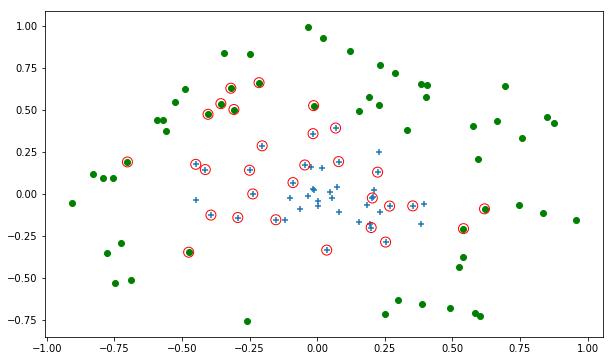

In [402]:
def calcErrRate(svm, X, y):
    m = X.shape[0]
    err_count = 0
    for i in range(m):
        y_hat = np.sign(svm.predict(X[i]))
#         print(np.sign(y_hat), np.sign(y[i]), np.sign(y_hat) != np.sign(y[i]))
        if (np.sign(y_hat) != np.sign(y[i])):
            err_count += 1
    return float(err_count / m)
    
## RBF 核测试, testSetRBF

df = loadData('testSetRBF.txt', names=['x1', 'x2', 'label'])
m, n = df.values.shape
X_train, y_train = df.values[:, 0:-1], df.values[:, -1:m]

df_test = loadData('testSetRBF2.txt', names=['x1', 'x2', 'label'])
m_test, n_test = df_test.values.shape
X_test, y_test = df_test.values[:, 0:-1], df.values[:, -1:m_test]

svm = SVM(X_train, y_train, C=200, toler=0.0001, kernel=rbfKernel, kernelParams=[1.3])
b, alphas = svm.smo(10000)

# print(svm.K[0])

print(np.nonzero(alphas)[0], len(np.nonzero(alphas)[0]))
print('The training error is :', calcErrRate(svm, X_train, y_train))
print('The testing error is :', calcErrRate(svm, X_test, y_test))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

# 画出正负样本，和支持向量
positives = X_train[np.nonzero(y_train == 1)[0], :]
negatives = X_train[np.nonzero(y_train != 1)[0], :]
supportVectors = X_train[np.nonzero(alphas > 0)[0], :]

ax.scatter(positives[:, 0], positives[:, 1], marker='+')
ax.scatter(negatives[:, 0], negatives[:, 1], c='g')
ax.scatter(supportVectors[:, 0], supportVectors[:, 1], s=100, facecolors='none', edgecolors='r')

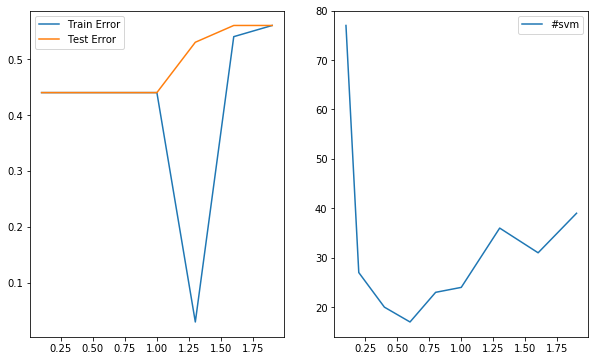

In [412]:

## RBF 核测试, testSetRBF
df = loadData('testSetRBF.txt', names=['x1', 'x2', 'label'])
m, n = df.values.shape
X_train, y_train = df.values[:, 0:-1], df.values[:, -1:m]

df_test = loadData('testSetRBF2.txt', names=['x1', 'x2', 'label'])
m_test, n_test = df_test.values.shape
X_test, y_test = df_test.values[:, 0:-1], df.values[:, -1:m_test]

sigmas = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.3, 1.6, 1.9]
train_err = []
test_err = []
svm_nums = []

for s in sigmas:
    svm = SVM(X_train, y_train, C=200, toler=0.0001, kernel=rbfKernel, kernelParams=[s])
    svm.smo(10000)
    svm_nums.append(len(np.nonzero(svm.alphas)[0]))
    train_err.append(calcErrRate(svm, X_train, y_train))
    test_err.append(calcErrRate(svm, X_test, y_test))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(121)
ax.plot(sigmas, train_err, label='Train Error')
ax.plot(sigmas, test_err, label='Test Error')
ax.legend()
ax = fig.add_subplot(122)
ax.plot(sigmas, svm_nums, label='#svm')
ax.legend()


**好像图像不太对呀，为什么 test 误差这么大。 **

### 作用核函数进行预测

使用了核函数后，我们分隔超平面的模型可以表示为:

$$
f(\textbf{x}) = \textbf{w}^T \phi(\textbf{x}) + b
$$

由于特征空间维数可能很高，甚至可能是无穷维的，因此直接计算 $\phi(\textbf{x}_i)^T\phi(\textbf{x}_j)$ 通常是困难的，可以设想一个这样的函数：

$$
k(\textbf{x}_i, \textbf{x}_j) = <\phi(\textbf{x}_i), \phi(\textbf{x}_j)> = \phi(\textbf{x}_i)^T\phi(\textbf{x}_j)
$$

最终我们求解的超平面为：

$$
\begin{align}
f(\textbf{x}) &= \textbf{w}^T \phi(\textbf{x}) + b \\
&= \sum_{i = 1}^{m} \alpha_i y_i \phi(\textbf{x}_i) \phi(\textbf{x}) + b \\
&= \sum_{i = 1}^{m} \alpha_i y_i k(\textbf{x}, \textbf{x}_i) + b
\end{align}
$$

所以我们预测时还是要用到核函数来进行下转换的。我们的核矩阵可以缓存下来。